<a href="https://colab.research.google.com/github/AllanKamimura/2021EstudosPython/blob/main/1%20-%20IA%20matrizes/Allan/heatmap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bibliotecas

In [ ]:
# importa as bibliotecas
import time
import scipy
import sympy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from IPython.display import clear_output

sns.set_theme("poster")

# Funções Auxiliares

In [ ]:
def gauss_seidel(A, b, w = 1, maxerro = 10 ** -3):
    D = A.diagonal()
    A = A / np.vstack(A.diagonal())
    b = b.squeeze() / A.diagonal()

    x = np.zeros(b.shape)

    upper = A - np.tril(A)
    lower = A - np.triu(A)

    for itera in range(10000):
        x_old = x.copy()
        for i in range(A.shape[0]):
            x[i] = (1 - w) * x[i] + w * (b[i] - lower[i] @ x - upper[i] @ x_old)
        
        erro = np.max(abs(x - x_old)) / max(np.max(abs(x_old)), 10 ** -7)

        if itera % 12 == 0:
            print("Erro: ", erro)
            clear_output(wait=True)

        if erro < maxerro:
            print(itera)
            break

    return x

In [ ]:
def draw(T, x_max, y_max, label, T_min, T_max, cmap = "rainbow"):
    i_max, j_max = T.shape
    
    sns.heatmap(T.T, 
                xticklabels = [int(np.linspace(0,x_max ,11)[int(x/int(i_max / 10))]) if x % int(i_max / 10) == 0 else "" for x in range(i_max + 1)],
                yticklabels = [int(np.linspace(0,y_max ,11)[int(y/int(j_max / 10))]) if y % int(j_max / 10) == 0 else "" for y in range(j_max + 1)],
                cmap = cmap, 
                cbar_kws = {"label": label, "extend": "both", "ticks": np.linspace(T_min,T_max ,7)},
                vmin = 1.1 * T_min, vmax = 1.1 * T_max
                ).invert_yaxis()
    
    _ = plt.yticks(rotation=0)
    return 

# Equação de Laplace para temperatura

$
\frac{\partial^{2}}{\partial x^{2}} T{\left(x,y \right)} + \frac{\partial^{2}}{\partial y^{2}} T{\left(x,y \right)} = 0
$

onde

$
\begin{cases}
(\delta x)^2\frac{\partial^{2}}{\partial x^{2}} T{\left(x,y \right)} = T{\left(x - 1,y \right)} - 2 T{\left(x,y \right)} + T{\left(x + 1,y \right)}
\\
(\delta y)^2\frac{\partial^{2}}{\partial y^{2}} T{\left(x,y \right)} = T{\left(x,y - 1 \right)} - 2 T{\left(x,y \right)} + T{\left(x,y + 1 \right)}
\end{cases}
$

Logo

$
4 T{\left(x,y \right)} = T{\left(x,y - 1 \right)} + T{\left(x,y + 1 \right)} + T{\left(x - 1,y \right)} + T{\left(x + 1,y \right)}
$

A temperatura de um ponto é igual a media aritmetica dos 4 pontos adjacentes

In [ ]:
# escreve a equação em LATEX
x = sympy.symbols("x")
y = sympy.symbols("y")
T = sympy.Function("T")

eq = sympy.Equality(sympy.diff(T(x,y),x,x) + sympy.diff(T(x,y),y,y),0)

print(sympy.latex(eq))
print("")
eq

\frac{\partial^{2}}{\partial x^{2}} T{\left(x,y \right)} + \frac{\partial^{2}}{\partial y^{2}} T{\left(x,y \right)} = 0



Eq(Derivative(T(x, y), (x, 2)) + Derivative(T(x, y), (y, 2)), 0)

In [ ]:
# metodo SOR 
# se quiser fazer o plot a cada iteração (demora muito mais)
plotar = False
plotar3d = False
folder = "fig" # nome da pasta onde as figuras são salvas
!mkdir ./$folder

def laplace_sor(T, x_max, y_max, w = 1, erromax = 10 ** -3):
    # inicializa as coisas
    i_max, j_max = T.shape
    x_step = x_max / (i_max - 1)
    y_step = y_max / (j_max - 1)
    beta = (x_step / y_step) ** 2 
    erro = 100 

    T_max = np.max(T)
    T_min = np.min(T)

    # faz a iteração
    for itera in range(100000):
        
        # armazena uma copia da matriz anterior
        T_old = T.copy()

        # aplica Gauss-Seidel com Sucessive Over Relaxation
        for i in range(1,i_max-1):
            for j in range(1,j_max-1):
                T[i,j] = T_old[i,j] * (1 - w) + w * (T[i + 1, j] + T[i - 1, j] + beta * (T[i, j + 1] + T[i, j - 1])) / (2 * beta + 2) 

        if plotar:
            # plota a figura a cada iteração
            plt.figure(figsize = (10,8)) #inicia a figura com um tamanho especifico

            label = "Temperatura (°C)"
            draw(T, x_max, y_max, label, T_min, T_max)

            plt.title("Iter: {}    Variação: {:.5f}".format(str(itera).zfill(3), erro))
            plt.tight_layout()
            plt.savefig("./{}/{}".format(folder, str(itera).zfill(3)))
            plt.close()

        if plotar3d:
            X, Y = np.meshgrid([i for i in range(i_max)], [j for j in range(j_max)])
            fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
            fig.set_size_inches((10,8)) #inicia a figura com um tamanho especifico
            _ = ax.plot_surface(X,Y,T.T, cmap = "rainbow", edgecolor='none')
            ax.view_init(elev = 15, azim=230)

            plt.title("Iter: {}    Variação: {:.5f}".format(str(itera).zfill(3), erro))
            plt.tight_layout()
            plt.savefig("./{}/{}".format(folder, str(itera).zfill(3)))
            plt.close()
        # calcula o erro, se for menor do que o threshold, para a iteração
        erro = np.max(np.abs(T - T_old)) / np.max(np.abs(T_old)) 
        if erro < erromax:
            break

    print(itera)
    return T

mkdir: cannot create directory ‘./fig’: File exists


91
Execution time: 59.48841


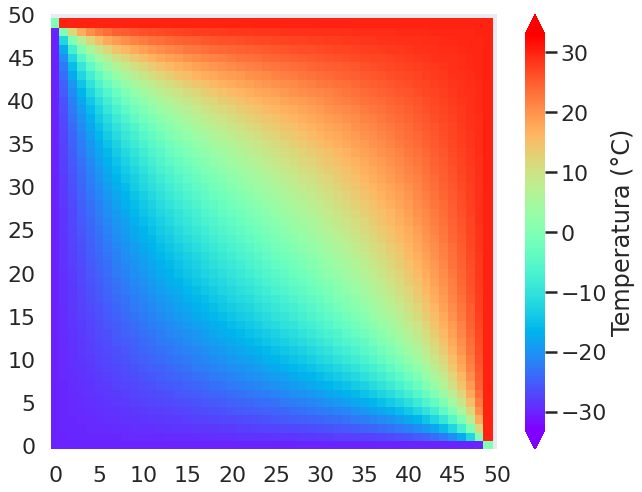

In [ ]:
# numero maximo de pontos na malha
i_max, j_max = 50, 50
T = np.zeros((i_max,j_max)) 

# aplica as condições de contorno
# temperatura das paredes é fixa
T[0,:]       =-30;
T[i_max-1,:] = 30;
T[:,j_max-1] = 30;
T[:,0]       =-30;
# temperatura nas 4 quinas é a media das paredes
T[i_max-1,j_max-1] = 0.5*(T[i_max-2,j_max-1] + T[i_max-1,j_max-2]);
T[0,0]             = 0.5*(T[1,0] + T[0,1]);
T[0,j_max-1]       = 0.5*(T[1,j_max-1] + T[0,j_max-2]);
T[i_max-1,0]       = 0.5*(T[i_max-2,0] + T[i_max-1,1]);

# inicia o cronometro
start_time = time.time()

# resolve as equações de laplace pras condições de contono
x_max, y_max = 50, 50
T = laplace_sor(T, x_max, y_max, w = 1.8)

# faz o plot
plt.figure(figsize = (10,8)) #inicia a figura com um tamanho especifico

T_max = np.max(T)
T_min = np.min(T)
label = "Temperatura (°C)"
draw(T, x_max, y_max, label, T_min, T_max)
_ = plt.yticks(rotation=0) 

# para o cronometro
print("Execution time: {:.5f}".format(time.time() - start_time))

In [ ]:
X, Y = np.meshgrid([i for i in range(i_max)], [j for j in range(j_max)])
fig = go.Figure(data=[go.Surface(x = X, y = Y, z = T.T, colorscale = "rainbow")])
fig.update_layout(width=800, height=800,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()

In [ ]:
# metodo de matriz

def laplace_matriz(T, x_max, y_max, w = 1, erromax = 10 ** -3):
    i_max, j_max = T.shape
    x_step = x_max / (i_max - 1)
    y_step = y_max / (j_max - 1)
    beta = (x_step / y_step) ** 2;
    
    A = np.zeros((i_max*j_max, i_max*j_max));
    b = np.zeros((i_max*j_max, 1));
    
    for i in range(i_max):
        for j in range(j_max):
            ind = i + j*i_max;

            # pontos a serem resolvidos
            if ( i > 0 and i < i_max -1 and j > 0 and j < j_max - 1):

                # pontos em volta do ponto desejado
                indip1        = (i+1) + (j+0)*i_max;
                indim1        = (i-1) + (j+0)*i_max;
                indjp1        = (i+0) + (j+1)*i_max;
                indjm1        = (i+0) + (j-1)*i_max;
                
                # coeficientes dos pontos ao redor
                A[ind,indip1] = 1;
                A[ind,indim1] = 1;
                A[ind,indjp1] = beta;
                A[ind,indjm1] = beta;
            
                # coeficiente do ponto a ser resolvido
                A[ind,ind]    = -2 - 2 * beta;

            # pontos das condições de contorno
            else:
                A[ind,ind] = 1;
                b[ind,0]   = T[i,j];

    # resolve o sistema
    T = scipy.sparse.linalg.spsolve(A, b)

    # reorganiza o vetor solução de volta para a matrix
    # pra entender oq ta acontecendo aqui, faz uns testes com matrizes pequenas
    T = np.reshape(np.reshape(T, (j_max, i_max)).T.flatten(), (i_max, j_max))

    return T

92
Execution time: 2.84408


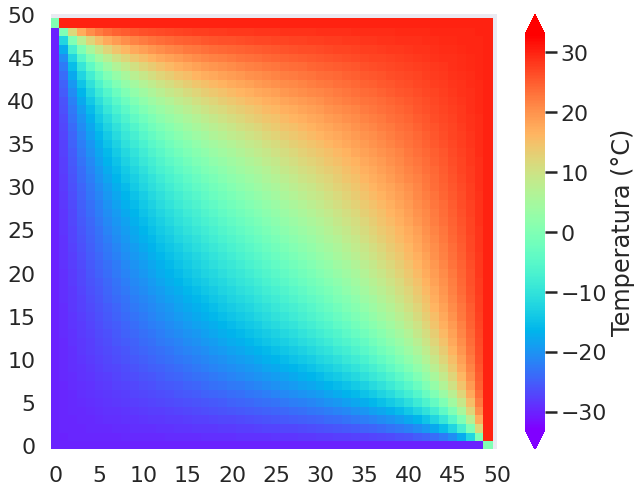

In [ ]:
# numero maximo de pontos na malha
i_max, j_max = 50, 50
T = np.zeros((i_max,j_max)) 

# aplica as condições de contorno
# temperatura das paredes é fixa
T[0,:]       =-30;
T[i_max-1,:] = 30;
T[:,j_max-1] = 30;
T[:,0]       =-30;
# temperatura nas 4 quinas é a media das paredes
T[i_max-1,j_max-1] = 0.5*(T[i_max-2,j_max-1] + T[i_max-1,j_max-2]);
T[0,0]             = 0.5*(T[1,0] + T[0,1]);
T[0,j_max-1]       = 0.5*(T[1,j_max-1] + T[0,j_max-2]);
T[i_max-1,0]       = 0.5*(T[i_max-2,0] + T[i_max-1,1]);

# inicia o cronometro
start_time = time.time()

# resolve as equações de laplace pras condições de contono
x_max, y_max = 50, 50
T = laplace_matriz(T.T, x_max, y_max, w = 1.8)

# faz o plot
plt.figure(figsize = (10, 8)) #inicia a figura com um tamanho especifico

T_max = np.max(T)
T_min = np.min(T)
label = "Temperatura (°C)"
draw(T, x_max, y_max, label, T_min, T_max)

# para o cronometro
print("Execution time: {:.5f}".format(time.time() - start_time))

In [ ]:
# criar o GIF
import os
import imageio

if plotar or plotar3d:
    pasta = folder
    imageio.plugins.freeimage.download()

    graph_list = os.listdir("/content/{}".format(pasta)) # lista de arquivos dentro da pasta
    graph_list = sorted(graph_list) # coloca os arquivos em ordem alfabetica

    images = []
    
    for image_file in graph_list: # pra cada arquivo dentro da pasta,
        if "checkpoints" not in image_file:
            image = imageio.imread("/content/{}/".format(pasta) + image_file) # ler o arquivo e armazenar em uma variavel
            images.append(image) # adicionar a image à lista de imagens

    imageio.mimsave("/content/{}.gif".format(pasta), images, "GIF-FI", fps = 10) # fazer um GIF com a lista de imagens